## Goal: get SNPs both CLOSE to SJs (exonic, +- 10 bp) and within SSs themselves

* 1. Use these to compute what % of novel SJs only in hap1/hap2 have a +- 10bp SNP OR SNP in the SS (should be very close to another I'm computing) AND
* 2. Subset on just known SJs to compute a known SJ-proximal SNP density score that I can use to correlate against the % increase in ICs / SJs detected to predict how much novel splicing we're missing in populations / samples that we actually didn't profile here
* Here, I want to get the indivdual set of info abotu % for each category (10bp OR ss)


In [54]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [55]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [56]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## We want to know what % of 1.5 NOVEL sjs that we 1. discover only in personal haplotypes that have snps +- 10 of splice junctions OR in splice sites

In [57]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel sjs
temp = df.loc[df.junction_novelty=='novel']

# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

In [58]:
temp.head()
assert len(temp.index) == len(temp[['sj_id', 'cell_line_id']].drop_duplicates().index)
len(temp.index)

14298

In [59]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_10nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    df = df.drop_duplicates()
    
    df['cell_line_id'] = c
    df['exon_10nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [60]:
assert len(sj_snp_df.index) == len(sj_snp_df[['sj_id', 'cell_line_id']].drop_duplicates().index)
assert len(sj_snp_df.index) == len(sj_snp_df.drop_duplicates().index)

In [61]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'exon_10nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.exon_10nt_has_var.fillna(False, inplace=True)

In [62]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['ss_2nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df

    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    df = df[['sj_id']]
    df = df.drop_duplicates()
    
    df['cell_line_id'] = c
    df['ss_2nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [63]:
assert len(sj_snp_df.index) == len(sj_snp_df[['sj_id', 'cell_line_id']].drop_duplicates().index)
assert len(sj_snp_df.index) == len(sj_snp_df.drop_duplicates().index)

In [64]:
temp = temp.merge(sj_snp_df[['sj_id', 'cell_line_id', 'ss_2nt_has_var']],
                  how='left',
                  on=['sj_id', 'cell_line_id'])
temp.ss_2nt_has_var.fillna(False, inplace=True)

In [65]:
temp['has_expl'] = temp.exon_10nt_has_var|temp.ss_2nt_has_var

temp.head()

,sj_id,cell_line_id,hap1,hap2,hg38,exon_10nt_has_var,ss_2nt_has_var,has_expl
0,GL000194.1_-_53893_55445,HG03729,False,True,False,False,False,False
1,GL000194.1_-_53893_55445,HG04217,False,True,False,False,False,False
2,GL000194.1_-_54956_55445,HG04217,False,True,False,False,False,False
3,KI270726.1_+_26127_26229,HG02261,True,False,False,False,False,False
4,chr10_+_100987611_100989643,NA19307,True,True,False,True,False,True


In [66]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['ss_2nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df

    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    
    df['cell_line_id'] = c
    df['ss_2nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [67]:
sj_snp_df.loc[(sj_snp_df.cell_line_id=='HG00621')&(sj_snp_df.sj_id=='chr10_+_60792054_60792122')]

,Chromosome,Start,End,Name,Score,Strand,sj_id,ThickEnd,ItemRGB,cell_line_id,ss_2nt_has_var


In [68]:
# 3. process snp content in each sj
sj_snp_df = pd.DataFrame()
for c in meta_df['cell_line_id_1000g'].tolist():
    file = proc_cfg(expand(config['lr']['td_personal']['exon_vars']['sj_10nt_vcf_intersect'],
                cell_line_id=c)[0],
                od)
    df = pr.read_bed(file).df
    
    # just keep uniq. sj_ids
    df.rename({'ThickStart': 'sj_id'}, axis=1, inplace=True)
    
    df['cell_line_id'] = c
    df['exon_10nt_has_var'] = True
    sj_snp_df = pd.concat([sj_snp_df, df], axis=0)

In [69]:
sj_snp_df.loc[(sj_snp_df.cell_line_id=='HG00621')&(sj_snp_df.sj_id=='chr10_+_60792054_60792122')]

,Chromosome,Start,End,Name,Score,Strand,sj_id,ThickEnd,ItemRGB,cell_line_id,exon_10nt_has_var
2583,chr10,60792122,60792132,.,.,+,chr10_+_60792054_60792122,end,10,HG00621,True


## First do a boxplot w/ just total % that have a variant

In [70]:

# how many vars are we talking per cell line?
temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# get # sjs that have explanation and perc
temp['n_sj_exp'] = temp.groupby(['cell_line_id', 'has_expl'])['sj_id'].transform('nunique')
temp['perc'] = (temp.n_sj_exp/temp.n_sj)*100

temp2 = temp[['cell_line_id', 'has_expl', 'n_sj', 'n_sj_exp', 'perc']].drop_duplicates()

In [71]:
temp2 = temp2.loc[temp2.has_expl==True]
len(temp2.index)

30

In [72]:
temp2.head()

,cell_line_id,has_expl,n_sj,n_sj_exp,perc
4,NA19307,True,467,215,46.038544
5,HG01952,True,577,245,42.461005
6,HG02261,True,695,308,44.316547
7,HG04217,True,514,211,41.050584
8,NA12878,True,463,242,52.267819


In [73]:
temp2.loc[temp2.cell_line_id=='HG00621']

,cell_line_id,has_expl,n_sj,n_sj_exp,perc
55,HG00621,True,764,333,43.586387


<AxesSubplot:ylabel='perc'>

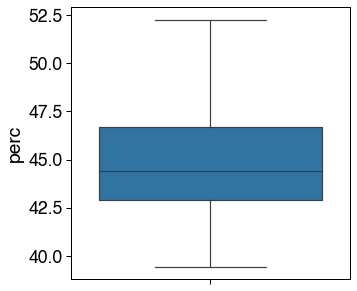

In [74]:
sns.boxplot(temp2,
            y='perc')

In [76]:
temp2.head()

,cell_line_id,has_expl,n_sj,n_sj_exp,perc
4,NA19307,True,467,215,46.038544
5,HG01952,True,577,245,42.461005
6,HG02261,True,695,308,44.316547
7,HG04217,True,514,211,41.050584
8,NA12878,True,463,242,52.267819


In [75]:
temp2.to_csv('250210_perc_novel_hg38_absent_sjs_w_variant_per_cell_line.tsv', sep='\t', index=False)

In [36]:
temp2 = pd.read_csv('250210_perc_novel_hg38_absent_sjs_w_variant_per_cell_line.tsv', sep='\t')


In [41]:
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')


,cell_line_id,has_expl,n_sj,n_sj_exp,perc,cell_line_id_1000g_x,map_reads_assemblymap,cell_line_id_1000g_y,population
0,NA19307,True,467,215,46.038544,NA19307,13165293.0,NA19307,LWK
1,HG01952,True,577,245,42.461005,HG01952,16931563.0,HG01952,PEL
2,HG02261,True,695,308,44.316547,HG02261,24396936.0,HG02261,PEL
3,HG04217,True,514,211,41.050584,HG04217,15900414.0,HG04217,ITU
4,NA12878,True,463,242,52.267819,NA12878,19493442.0,NA12878,CEU


In [47]:
temp2.head()

,cell_line_id,has_expl,n_sj,n_sj_exp,perc,cell_line_id_1000g_x,map_reads_assemblymap,cell_line_id_1000g_y,population
0,NA19307,True,467,215,46.038544,NA19307,13165293.0,NA19307,LWK
1,HG01952,True,577,245,42.461005,HG01952,16931563.0,HG01952,PEL
2,HG02261,True,695,308,44.316547,HG02261,24396936.0,HG02261,PEL
3,HG04217,True,514,211,41.050584,HG04217,15900414.0,HG04217,ITU
4,NA12878,True,463,242,52.267819,NA12878,19493442.0,NA12878,CEU


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  


<AxesSubplot:xlabel='population', ylabel='perc'>

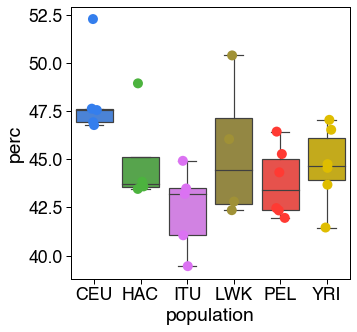

In [48]:
c_dict, order = get_population_colors(cats=temp2.population.unique().tolist())

ax = sns.boxplot(temp2,
            x='population',
            y='perc',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='perc', data=temp2, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')

In [37]:
temp2.perc.median()


44.4328359654134

In [34]:
temp2.n_sj_exp.median()

205.5

In [35]:
temp2.n_sj.median()

465.0

In [21]:
# what detection categories do we even have? 
temp[['exon_10nt_has_var', 'ss_2nt_has_var']].drop_duplicates()

,exon_10nt_has_var,ss_2nt_has_var
0,False,False
4,True,False
13,False,True
84,True,True


In [22]:
# how many vars are we talking per cell line?
temp['n_sj'] = temp.groupby(['cell_line_id'])['sj_id'].transform('nunique')

# for each combination of explanations, what % of sjs are explained?
# (and for each cell line)
temp['n_sj_w_explanation'] = temp.groupby(['cell_line_id', 'exon_10nt_has_var', 'ss_2nt_has_var'])['sj_id'].transform('nunique')
temp['perc_sj_w_explanation'] = (temp['n_sj_w_explanation']/temp['n_sj'])*100

In [23]:
keep_cols = ['exon_10nt_has_var', 'ss_2nt_has_var', 
              'n_sj', 'n_sj_w_explanation', 'perc_sj_w_explanation',
             'cell_line_id']
temp = temp[keep_cols]
print(len(temp.index))
temp = temp.drop_duplicates()
print(len(temp.index))

14298
120


In [24]:
temp['# SJs'] = temp.n_sj
temp['% SJs'] = temp.perc_sj_w_explanation

In [25]:
temp.rename({'exon_10nt_has_var': 'Exonic variant\n+-10bp from SJ', 
             'ss_2nt_has_var': 'SS variant'}, axis=1, inplace=True)

In [26]:
temp.set_index(['Exonic variant\n+-10bp from SJ', 'SS variant'], inplace=True)
temp.head()

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 325   
                               False        514                 303   
                               False        695                 387   
True                           False        467                 150   
                               False        577                 184   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   56.521739      HG03729   
                               False                   58.949416      HG04217   
                               False                   55.683453      HG02261   
True                           False                   32.119914      NA19307   
                               False                   31.889081      HG01952   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  56.521739  
                               False         514  58.949416  
                               False         695  55.683453  
True                           False         467  32.119914  
                               False         577  31.889081

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


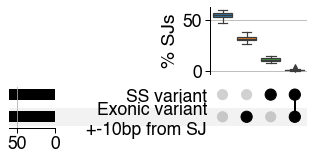

In [27]:
init_plot_settings()
fig = plt.figure(figsize=(10, 16))
# plot(example, fig=fig, element_size=None)
upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
upset.add_catplot(
    kind='box',
    value='% SJs')
upset.plot(fig=fig)
# plt.suptitle('Novel personalized-GRCh38\nexclusive SJs')
plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


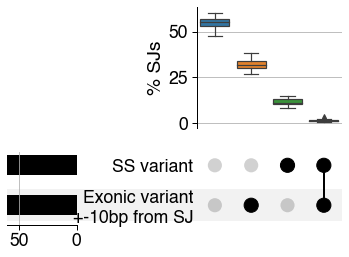

In [28]:
init_plot_settings()
fig = plt.figure(figsize=(6, 4))
# plot(example, fig=fig, element_size=None)
upset = upsetplot.UpSet(temp, intersection_plot_elements=0, element_size=None)  # disable the default bar chart
upset.add_catplot(
    kind='box',
    value='% SJs')
upset.plot(fig=fig)
# plt.suptitle('Novel personalized-GRCh38\nexclusive SJs')
plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

In [29]:
temp.head()

n_sj  n_sj_w_explanation  \
Exonic variant\n+-10bp from SJ SS variant                             
False                          False        575                 325   
                               False        514                 303   
                               False        695                 387   
True                           False        467                 150   
                               False        577                 184   

                                           perc_sj_w_explanation cell_line_id  \
Exonic variant\n+-10bp from SJ SS variant                                       
False                          False                   56.521739      HG03729   
                               False                   58.949416      HG04217   
                               False                   55.683453      HG02261   
True                           False                   32.119914      NA19307   
                               False                   31.889081      HG01952   

                                           # SJs      % SJs  
Exonic variant\n+-10bp from SJ SS variant                    
False                          False         575  56.521739  
                               False         514  58.949416  
                               False         695  55.683453  
True                           False         467  32.119914  
                               False         577  31.889081

In [49]:
temp.to_csv('250221_personal_hg38_unique_novel_explainability.tsv', sep='\t')


In [50]:
temp = pd.read_csv('250221_personal_hg38_unique_novel_explainability.tsv', sep='\t')

In [53]:
temp.head()

,Exonic variant\n+-10bp from SJ,SS variant,n_sj,n_sj_w_explanation,perc_sj_w_explanation,cell_line_id,# SJs,% SJs
0,False,False,575,325,56.521739,HG03729,575,56.521739
1,False,False,514,303,58.949416,HG04217,514,58.949416
2,False,False,695,387,55.683453,HG02261,695,55.683453
3,True,False,467,150,32.119914,NA19307,467,32.119914
4,True,False,577,184,31.889081,HG01952,577,31.889081


In [ ]:
temp2 = temp.loc[('Exonic variant\n+-10bp from SJ'==True)|
                 ('SS variant'==True)]